# Estimating a Yield Curve Model

In [1]:
using Optim, PyPlot

include("jlFiles/printmat.jl")
include("jlFiles/lagnPs.jl")

lagnPs (generic function with 2 methods)

In [2]:
xx = readdlm("Data/USCMRatesPs.csv",',',header=true)
y  = xx[1]

YearMonth = 1970 + 1/24 + (1/12)*collect(0:size(y,1)-1)

y[:,1] = ((1-0.25*y[:,1]/100).^(-1/0.25) - 1)*100    #discount basis->effective
y[:,2] = ((1-0.50*y[:,2]/100).^(-1/0.5) - 1)*100

m      = [0.25 0.5 1 3 5 7 10]                             #time to maturity (in years)
mMonth = broadcast(x->round(Int,x),m*12)                   #maturites, in months (integers)
y      = log.(1+y/100)                    #continuously compounded interest rates
y      = y/12                            #interest rates per month (the period length of data)

(T,n) = size(y)

(520,7)

## Establishing Notation for an Affine Yield Curve Model


An affine yield curve model implies that the yield on an $n$-period discount
bond is

$$
\begin{equation}
y_{nt}=a_{n}+b_{n}^{\prime}x_{t}\nonumber
\end{equation}
$$

where $x_{t}$ is an $K\times1$ vector of state variables. Here $a_{n}$ is a
scalar and $b_{n}$ is a $K\times1$ vector (so $b_{n}^{\prime}x_{t}$ is a scalar). 

Transpose to get
$$
y_{nt}=a_{n}+\underset{1\times K}{\underbrace{x_{t}^{\prime}}}
\underset{K\times1}{\underbrace{b_{n}}}
$$

As an example, consider two different maturities ($n$), denoted $1$ and $2$.
The row vector is then

$$
\begin{bmatrix}
y_{1t} & y_{2t}
\end{bmatrix} =
\begin{bmatrix}
a_{1} & a_{2}
\end{bmatrix}
+x_{t}^{\prime}
\begin{bmatrix}
b_{1} & b_{2}
\end{bmatrix}.
$$

Now, stack observations ($t=1$ to $T$) vertically

$$
Y_{T\times n}=\mathbf{1}_{T\times1}\otimes a_{1\times n}+X_{T\times K}b_{K\times n},
$$

where $\mathbf{1}_{T\times1}$ is a $T\times1$ vector of ones and $\otimes$ is
the Kronecker product.

An example of the Kronecker product:
$$
\mathbf{1}_{2\times1}\otimes
\begin{bmatrix}
1 & 2 & 3
\end{bmatrix} =
\begin{bmatrix}
1 & 2 & 3\\
1 & 2 & 3
\end{bmatrix}.
$$

### From Model Parameters to $a_{n}$ and $b_{n}$

The following function VasicekABFn.jl takes the
Vasicek model parameters as inputs and calculates the $a_{n}$ and $b_{n}$ values.

In [3]:
function VasicekABFn(lambda,mu,rho,sigma,nMo,nMu,yo)

  nMax = maximum([nMo;nMu])    #longest maturity to calculate (a,b) for
  Nvec = 1:nMax

  A = fill(NaN,(1,nMax))              #recursive solution of AR(1) model
  B = fill(NaN,(1,nMax))
  B[1] = 1 + 0*rho
  A[1] = 0 + 0*(1-rho)*mu - (lambda+0)^2*sigma^2/2
  for n = 2:nMax
    B[n] = 1 + B[n-1]*rho
    A[n] = A[n-1] + B[n-1]*(1-rho)*mu - (lambda+B[n-1])^2*sigma^2/2
  end

  a  = A./Nvec'
  b  = B./Nvec'

  ao = a[:,nMo][1]                       #required maturities
  bo = b[:,nMo][1]                       #[1] to make sure the are scalar

  xt    = (yo-ao)/bo                     #value of state variable x(t)

  au    = a[:,nMu]
  bu    = b[:,nMu]
  yuHat = au .+ xt*bu                   #Txn, fitted values of yu

  return ao,bo,xt,au,bu,yuHat

end

VasicekABFn (generic function with 1 method)

### Testing the VasicekABFn Function

ao and bo: 


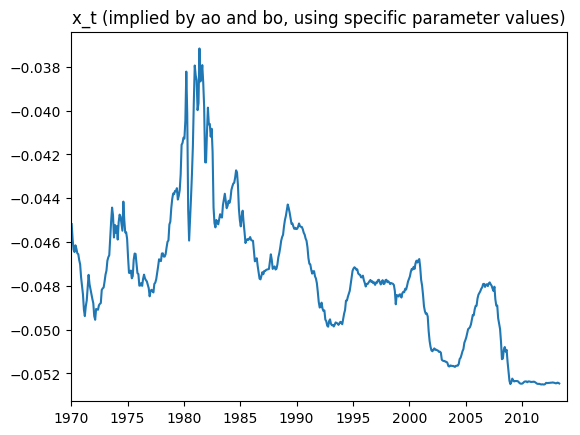

     0.047     0.903



In [4]:
vvo = 1                               #indices of yields that are observed without errors
vvu = 2:n                             #indices of yields with observation errors

yo = y[:,vvo]                         #observable yields
yu = y[:,vvu]                         #unobservable yields
nMo = mMonth[vvo]                     #maturity of yo
nMu = mMonth[vvu]                     #maturity of yu


#just testing the Vasicek functions
(ao,bo,xt,au,bu,yuHat) = VasicekABFn(1,0.5,0.9,0.02,nMo,nMu,yo)

println("ao and bo: ")
printmat([ao bo])

figure()
  ha = plot(YearMonth,xt)
  xlim(1970,2014)
  title("x_t (implied by ao and bo, using specific parameter values)")
show()

## The Likelihood Function

To formulate the log-liklihood, the VasicekTsCsFn
first takes the parameter vectors and transforms the parameters (scaling,
making sure that $-1\leq\rho\leq1$, etc) and the calls on the function
VasicekABFn (see above).


From the previous output, the code in VasicekTsCsFn moves on to
define the 1-step ahead forecast errors of $y_{ot}$ as

$$
v_{t}=y_{ot}-E_{t-1}y_{ot}
$$

and its variance $S=b_{o}^{\prime}\sigma^{2}b_{o}$. The contribution to the
likelihood function in $t$ is proportional to $v_{t}^{\prime}S^{-1}v_{t}$.
Then, the code defines the cross-sectional errors (for $y_{ut}$) as

$$
u_{t}=y_{ut}-\hat{y}_{ut} \ \text{, where } \ \hat{y}_{ut}=a_{u}+b_{u}^{\prime}x_{t},
$$

The contribution to the likelihood function is $u_{t}^{\prime}\Omega^{-1}
u_{t}$, where the code assumes that $\Omega$ is diagonal,
$
\Omega=I\omega^{2},
$
where $\omega$ is one of the parameters estimated. 

The function VasicekTsCsLossFn creates
the value of the function that will be minimized.

In [5]:
function VasicekTsCsFn(par,yo,yu,nMo,nMu)
#VasicekTsCsFn    Loss function for estimating the Vasicek model using both
#                 time series and cross sectional information

  J = length(nMu)
  T = size(yo,1)

  lambda  = par[1]*100
  mu      = par[2]/1200
  p       = 1 - 2/(1+exp(par[3]))          #inverse: par[3] = log((1+p)/(1-p))
  s2      = (par[4]/1200)^2
  omega_i = abs(par[5]/1200)

  if length(nMo) != 1
    error("yo must be a single yield")
  end

  (ao,bo,xt,au,bu,yuHat) = VasicekABFn(lambda,mu,p,sqrt(s2),nMo,nMu,yo)

  Et1xt    = (1-p)*mu + p*lagnPs(xt)    #E(t-1)x(t)
  Et1xt[1] = mu
  Et1yo    = ao + Et1xt*bo              #E(t-1)yo(t)
  v        = yo - Et1yo                 #Tx1, forecast error of yo
  S        = bo's2*bo                   #variance of forecast error of yo
  S_1      = inv(S*1000)*1000           #1000/1000 improves the precision a bit
  LLo_t    = -0.5*log(2*pi) - 0.5*log(det(S)) - 0.5*sum(v*S_1.*v,2)   #Tx1

  u        = yu -  yuHat                 #TxL, fitted errors of yu
  Omega    = eye(J)*omega_i^2
  Omega_1  = inv(Omega)                  #covariance matrix of u
  LLu_t    = -0.5*J*log(2*pi) - 0.5*log(det(Omega)) - 0.5*sum(u*Omega_1.*u,2)  #Tx1

  LL_t    = LLo_t + LLu_t                #Tx1, log likelihood(t), sum of TS and CS
  
  return LL_t,yuHat,u,xt

end


function VasicekTsCsLossFn(par,yo,yu,nMo,nMu)
  LL_t, = VasicekTsCsFn(par,yo,yu,nMo,nMu)
  MinusLL = -sum(LL_t[2:end])            #to be minimized 
  return MinusLL
end

VasicekTsCsLossFn (generic function with 1 method)

In [6]:
#notice: important that the elements of the parameter vector have similar magnitude
#lambda/100,mu*1200,p = 1 - 2/(1+exp(par(3))) so 5.6 -> p = 0.993,sigma*1200,omega*1200
par0 = [-2.3;10;5.5;0.5;0.8]

MinusLL = VasicekTsCsLossFn(par0,yo,yu,nMo,nMu)

printlnPs("The negative of the log-likelihood function at the starting guess: ",MinusLL)

The negative of the log-likelihood function at the starting guess: -21632.802


In [7]:
                             #do MLE by optimization with optimize, minimize -sum(LL)
Sol = optimize(par->VasicekTsCsLossFn(par,yo,yu,nMo,nMu),par0)
par1 = Optim.minimizer(Sol)

println("\npar0 and par1")
printmat([par0 par1])

#converting back to model parameters 
(lambda,mu,rho,s2) = (par1[1]*100,par1[2]/1200,1 - 2/(1+exp(par1[3])),par1[4]/1200)
println("Estimated (lambda,mu,rho,s2):")
printmat([lambda mu rho s2])


par0 and par1
    -2.300    -2.441
    10.000     9.672
     5.500     5.753
     0.500     0.525
     0.800     0.797

Estimated (lambda,mu,rho,s2):
  -244.095     0.008     0.994     0.000



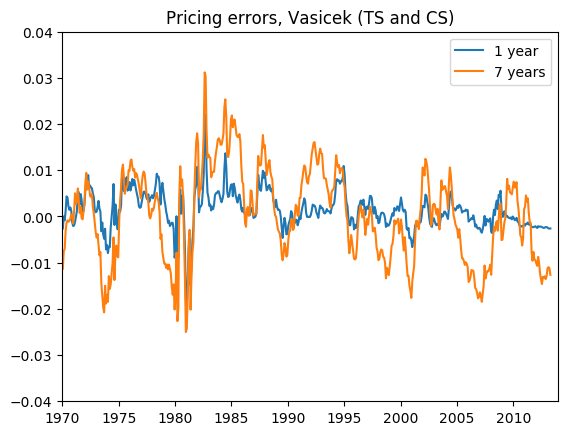

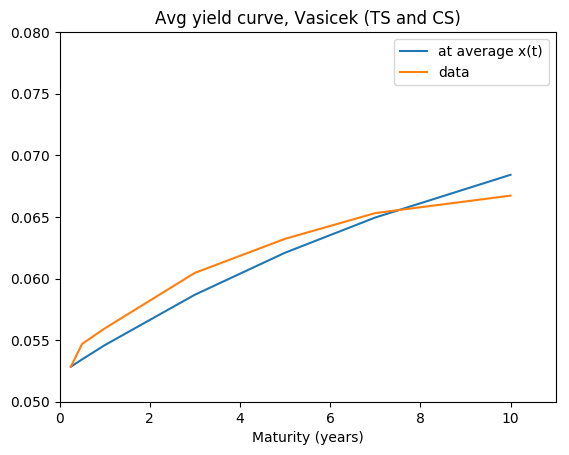

The negative of the log-likelihood function at the point estimate: -21671.211618944784


In [8]:
                                               #fitted yields at parameter estimates
MinusLL = VasicekTsCsLossFn(par1,yo,yu,nMo,nMu)
println("The negative of the log-likelihood function at the point estimate: ",MinusLL)

(LL_t,yuHat,u,xt) = VasicekTsCsFn(par1,yo,yu,nMo,nMu)

yhatTsCs = [yo yuHat]                      #also yo

                                            #a and b at estimated parameters, average yield curve
(ao,bo,xt,au,bu,yuHatAvg) = VasicekABFn(lambda,mu,rho,s2,nMo,nMu,mean(yo))
yuHatAvg = [mean(yo) yuHatAvg]             #also yo


figure()
  yy = y[:,[3,6]] - yhatTsCs[:,[3,6]]
  ha = plot(YearMonth,12*yy)
  xlim(1970,2014)
  ylim(-0.04,0.04)
  title("Pricing errors, Vasicek (TS and CS)")
  legend(["1 year";"7 years"])
show()

figure()
  ha = plot(m',12*[yuHatAvg' mean(y,1)'])
  xlim(0,11)
  ylim(0.05,0.08)
  title("Avg yield curve, Vasicek (TS and CS)")
  legend(["at average x(t)";"data"])
  xlabel("Maturity (years)")
show()

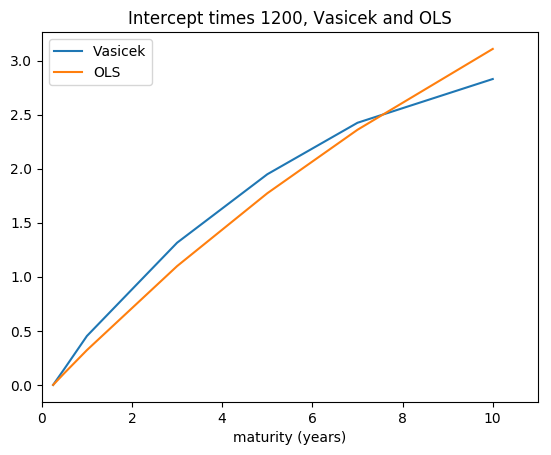

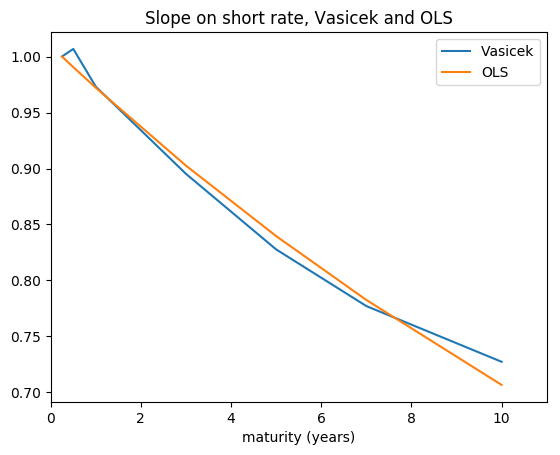

In [9]:
bOls = [ones(T) y[:,1]]\y                 #LS of yields on short yield
alfa = bOls[1:1,:]
beta = bOls[2:2,:]
                         #rescaling Vasicek au and bu to be comaparable with OLS on yo
bu_b = bu/bo             #y = au + bu*xt, but xt = (yo-ao)/bo
au_b = au - bu/bo*ao     #y = au + bu*(yo-ao)/bo = y = au - bu*ao/bo + bu/bo*yo
bu_b = [1 bu_b]          #also yo
au_b = [0 au_b]

figure()
  ha = plot(m',[alfa' au_b']*1200)
  xlim(0,maximum(m)+1)
  title("Intercept times 1200, Vasicek and OLS")
  xlabel("maturity (years)")
  legend(["Vasicek";"OLS"])
show()

figure()
  ha = plot(m',[beta' bu_b'])
  xlim(0,maximum(m)+1)
  title("Slope on short rate, Vasicek and OLS")
  xlabel("maturity (years)")
  legend(["Vasicek";"OLS"])
show()